# Обычная линейная модель
Предсказать среднюю цену номера в отеле в долларах (Average Daily Rate (in $))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#  matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
# открываю доступ к диску
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
import os

os.chdir("/content/drive/My Drive/colab/AD")

### Прогнозирование временных рядов. Вариант 4.

In [ ]:
# считываем данные
df = pd.read_csv('Chicago_hotels.csv', sep=';', decimal=',')
df.head()

,date1,date2,x1,x2,x3,x4
0,January,1994,"44,3","104,04","51,9","72,15"
1,February,1994,"54,7","102,74","60,1","73,47"
2,March,1994,"61,9","105,23",65,"74,91"
3,April,1994,"69,1","113,63","69,8","79,06"
4,May,1994,"70,8","120,77","72,4","82,07"


In [ ]:
# привожу в удобный формат
df['x4'] = [float(data.replace(',', '.')) for data in df['x4'] if data != ' ']+[np.nan]*8
df['month_num'] = range(1, len(df) + 1)

Посмотрим на распределение

Text(0, 0.5, 'log10 от долларов')

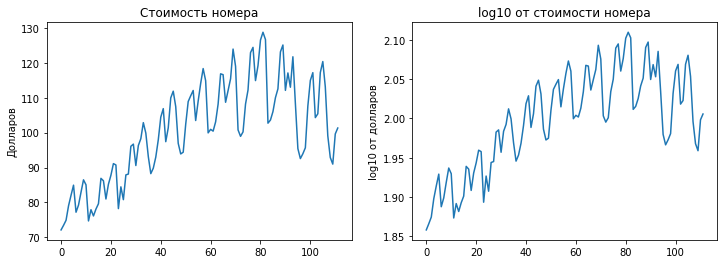

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['x4'].plot(ax=ax1)
ax1.set_title(u'Стоимость номера')
ax1.set_ylabel(u'Долларов')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['x4'])).plot(ax=ax2)
ax2.set_title(u'log10 от стоимости номера')
ax2.set_ylabel(u'log10 от долларов')


Я не вижу надобности в логарифмировании.

In [ ]:
# удаляю ненужные переменные
del df['x3']
del df['x2']
del df['x1']

In [ ]:
# удобная штука, которая разбивает категориальные переменные (ван хот энкодинг)
df = pd.get_dummies(df, columns=['date1'],drop_first=True) # удалили столбец - избавились от линейной зависимости
df_n = df.copy()

In [ ]:
for i in range(119, 111, -1):
  df_n = df_n.drop([i])

In [ ]:
y = df_n['x4']
X = df_n.drop(columns=["x4", "date2","date1_January", "date1_February", "date1_March"])
#  Подгонка модели
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,76.105257
1,month_num,0.316898
2,date1_August,8.915116
3,date1_December,-1.675810
4,date1_July,5.317569
5,date1_June,14.570023
6,date1_May,13.526921
7,date1_November,12.433310
8,date1_October,17.227986
9,date1_September,13.069329


In [ ]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

In [ ]:
# проверка гипотез и коэф-ты
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,76.105257,0.000000e+00
1,month_num,0.316898,0.000000e+00
2,date1_August,8.915116,1.911302e-03
3,date1_December,-1.675810,5.514116e-01
4,date1_July,5.317569,6.050100e-02
5,date1_June,14.570023,9.358725e-07
6,date1_May,13.526921,4.538651e-06
7,date1_November,12.433310,2.188463e-05
8,date1_October,17.227986,1.286458e-08
9,date1_September,13.069329,8.800339e-06


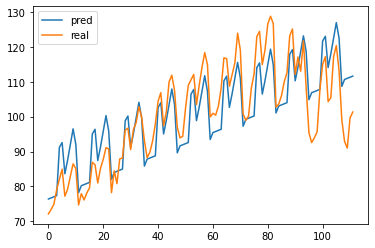

In [ ]:
#  Сравним подгонку

pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

Не очень. Посмотрим, что будет дальше.

In [ ]:
pred.head(14)

,pred,real
0,76.422155,72.15
1,76.739053,73.47
2,77.055951,74.91
3,77.372849,79.06
4,91.216669,82.07
5,92.576669,84.96
6,83.641113,77.22
7,87.555558,79.25
8,92.026669,82.93
9,96.502224,86.49


In [ ]:
# строим матрицу для теста
# я заранее сделала вычисления в большой матрице, можно просто взять нужный кусок в 8 последних месяцев
z = df.copy()
for i in range(111, -1, -1):
  z = z.drop([i])

In [ ]:
# и удалить ненужные колонки
z = z.drop(columns=["x4", "date2", "date1_January", "date1_February", "date1_March"])

In [ ]:
z

,month_num,date1_August,date1_December,date1_July,date1_June,date1_May,date1_November,date1_October,date1_September
112,113,0,0,0,0,1,0,0,0
113,114,0,0,0,1,0,0,0,0
114,115,0,0,1,0,0,0,0,0
115,116,1,0,0,0,0,0,0,0
116,117,0,0,0,0,0,0,0,1
117,118,0,0,0,0,0,0,1,0
118,119,0,0,0,0,0,1,0,0
119,120,0,1,0,0,0,0,0,0


In [ ]:
model.predict(z)

array([125.44166414, 126.80166414, 117.86610859, 121.78055303,
       126.25166414, 130.7272197 , 126.24944192, 112.4572197 ])

Построим график:

In [ ]:
#  матрица с подгонкой
pred['forecast'] = np.nan

In [ ]:
df_4 = pd.DataFrame(model.predict(z), columns=['forecast'])
df_4['real'] = np.nan
df_4['pred'] = np.nan


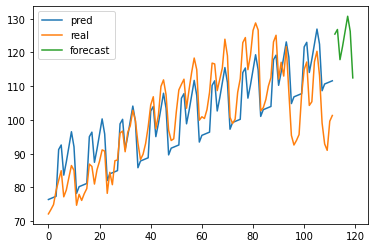

In [ ]:
#  объединяем матрицы, задаем новые индексы
pred_1 = pd.concat(
    [pred, df_4],
    sort=False
).reset_index(drop=True)

pred_1.plot()

Завышенные значения, на мой взгляд. Нужно что-то менять!